### 딥러닝 CNN 프로젝트 보고서

#### Vehicle 분류
- 고용량 데이터(5GB) + 유사도가 높은 데이터 세트
- 미세 조정 진행

데이터 이미지 확인합니다.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

root = './datasets/vehicles/original/'

idg = ImageDataGenerator(rescale=1./255)

generator = idg.flow_from_directory(root, target_size = (150, 150), batch_size=32, class_mode='categorical')
# print(generator.class_indices)

Found 22852 images belonging to 17 classes.


In [2]:
target_name = {v : k for k, v in generator.class_indices.items()}
# print(target_name)

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def show_images(generator, ncols=8):

    random_indices = np.random.choice(len(generator.filepaths), 8, replace=False)
    #print(random_indices)

    target_name = {v : k for k, v in generator.class_indices.items()}
    
    target_names = []
    
    for target in generator.classes:
        target_names.append(target_name[target])

    # print(target_names)
    images = []
    indices= []

    
    for index in random_indices:
        image = cv2.cvtColor(cv2.imread(generator.filepaths[index]), cv2.COLOR_BGR2RGB)
        images.append(image)
        indices.append(index)
    
    fig, axes = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i, index in zip(range(ncols), indices):
        axes[i].imshow(images[i])
        axes[i].axis('off')
        axes[i].set_title(target_names[index])


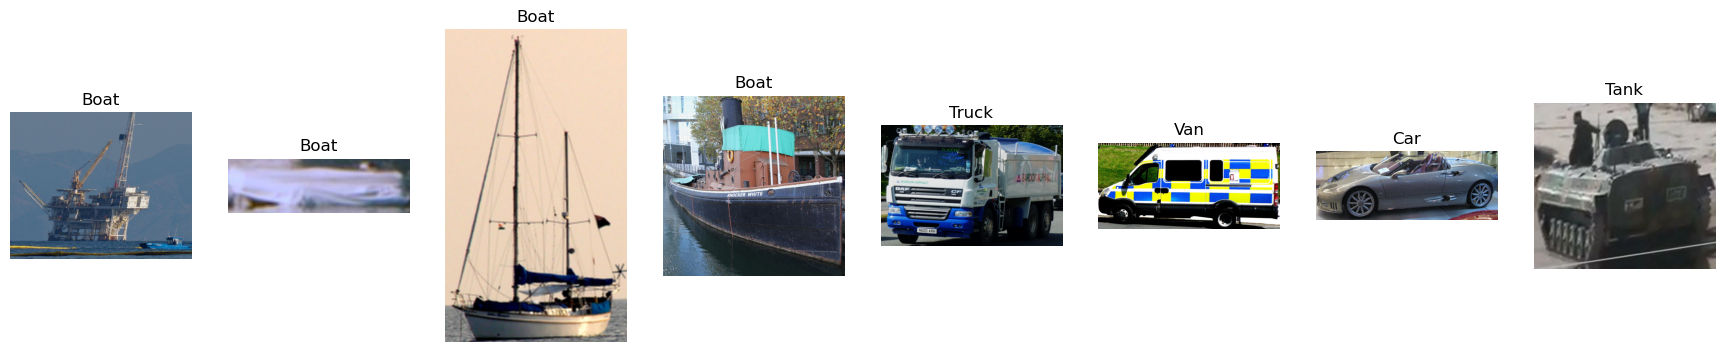

In [4]:
show_images(generator)

---
### Cycle 1
- 사용한 사전 훈련 모델 : `VGG16`
- 사용한 분류기
- IMAGE_SIZE = 224, BATCH_SIZE = 64

<code>
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(300, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(17, activation='softmax', name='output')(x)
</code>


- Total params : 14,873,705
- Albumentation 적용 X
- Learning_rate : default

- 훈련 Epoch : 20 / 20

> 1 Epoch당 평균 훈련 시간 : 약 786s (13분)  
> 총 훈련 시간 : 15,719s (4시간 20분)

<style>
    table {
        margin-left: 0;
    }
</style>

<table style="margin-left: 0">
    <tr>
        <th></th>
        <th>Train</th>
        <th>Validation</th>
        <th>Test</th>
    </tr>
    <tr>
        <td>Accuracy</td>
        <td>0.8209</td>
        <td>0.7493</td>
        <td>0.6617</td>
    </tr>
    <tr>
        <td>Loss</td>
        <td>0.5426</td>
        <td>0.7942</td>
        <td>1.1564</td>
    </tr>
</table>

- history 시각화
  
<img src="./images/vehicle/cycle1_history.png" width="500px">

- 예측 수행
<img src="./images/vehicle/cycle1_prediction.png" width="1200px">

- 임의 8개 중에 6개만을 맞추는 것을 확인했습니다.
- train과 validation & test 점수의 차이가 나는 것으로 보아, 과적합의 위험이 있다고 판단이 되어, Albumentation을 적용합니다.

---
### Cycle 2
- 사용한 사전훈련 모델 : `VGG16`
- 사용한 분류기
- IMAGE_SIZE = 224, BATCH_SIZE = 64

<code>
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(300, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(17, activation='softmax', name='output')(x)
</code>

- Total params : 14,873,705
- Albumentation 적용 O

<code>
    aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.GaussNoise(p=0.5, var_limit=(400, 900)),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5)])
    
</code>

- Learning_rate : default
- 훈련 Epoch : 20 / 20

> 1 Epoch당 평균 훈련 시간 : 약 1903s (약 31분)  
> 총 훈련 시간 : 38,067s (약 10시간 34분)

<style>
    table {
        margin-left: 0;
    }
</style>

<table style="margin-left: 0">
    <tr>
        <th></th>
        <th>Train</th>
        <th>Validation</th>
        <th>Test</th>
    </tr>
    <tr>
        <td>Accuracy</td>
        <td>0.6902</td>
        <td>0.6996</td>
        <td>0.6858</td>
    </tr>
    <tr>
        <td>Loss</td>
        <td>0.9755</td>
        <td>0.9569</td>
        <td>1.0923</td>
    </tr>
</table>

- history 시각화
  
<img src="./images/vehicle/cycle2_history.png" width="500px">

- 예측 수행
<img src="./images/vehicle/cycle2_prediction.png" width="1200px">

- Accuracy 점수가 Train, Validation, Test 모두 떨어졌고, Loss 값 또한 증가함을 알 수 있었습니다.
- 임의 8개 중에 3개를 맞추는 오히려 성능이 더 떨어졌습니다.
- VGG16 보다 더 성능이 좋다고 알려진 EfficientNet 사전모델을 이용하여 훈련을 진행합니다.

---
### Cycle 3
- 사용한 사전훈련 모델 : `EfficientNet`
- 사용한 분류기
- IMAGE_SIZE = 224, BATCH_SIZE = 64

<code>
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(300, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(17, activation='softmax', name='output')(x)
</code>

- Total params : 6,308,729
- Albumentation 적용 O

<code>
    aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.GaussNoise(p=0.5, var_limit=(400, 900)),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5)])
    
</code>

- Learning_rate : default
- 훈련 Epoch : 19 / 20

> 1 Epoch당 평균 훈련 시간 : 약 507s (약 8분)  
> 총 훈련 시간 : 9633s (약 2시간 40분)

<style>
    table {
        margin-left: 0;
    }
</style>

<table style="margin-left: 0">
    <tr>
        <th></th>
        <th>Train</th>
        <th>Validation</th>
        <th>Test</th>
    </tr>
    <tr>
        <td>Accuracy</td>
        <td>0.9108</td>
        <td>0.9061</td>
        <td>0.8697</td>
    </tr>
    <tr>
        <td>Loss</td>
        <td>0.2728</td>
        <td>0.2920</td>
        <td>0.4898</td>
    </tr>
</table>

- history 시각화
  
<img src="./images/vehicle/cycle3_history.png" width="500px">

- 예측 수행
<img src="./images/vehicle/cycle3_prediction.png" width="1200px">

- Accuracy 점수가 Train, Validation, Test 모두 VGG모델보다 증가하였고, Loss 값은 줄어들었음을 확인하였습니다.
- 임의 8개 중에 7개를 맞추어 성능이 좋다는 것을 확인하였습니다.
- EfficienceNet 만큼 큰 용량의 데이터에 성능이 좋다고 알려진 DenseNet으로 훈련을 진행합니다.

---
### Cycle 4
- 사용한 사전훈련 모델 : `DenseNet201`
- 사용한 분류기
- IMAGE_SIZE = 224, BATCH_SIZE = 64

<code>
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(300, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(17, activation='softmax', name='output')(x)
</code>

- Total params : 18,903,401
- Albumentation 적용 O

<code>
    aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.GaussNoise(p=0.5, var_limit=(400, 900)),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5)])
    
</code>

- Learning_rate : default
- 훈련 Epoch : 17 / 20

> 1 Epoch당 평균 훈련 시간 : 약 2,162s (약 36분)  
> 총 훈련 시간 : 36,752s (약 10시간 10분)

<style>
    table {
        margin-left: 0;
    }
</style>

<table style="margin-left: 0">
    <tr>
        <th></th>
        <th>Train</th>
        <th>Validation</th>
        <th>Test</th>
    </tr>
    <tr>
        <td>Accuracy</td>
        <td>0.8548</td>
        <td>0.8558</td>
        <td>0.8133</td>
    </tr>
    <tr>
        <td>Loss</td>
        <td>0.4520</td>
        <td>0.4816</td>
        <td>0.6821</td>
    </tr>
</table>

- history 시각화
  
<img src="./images/vehicle/cycle4_history.png" width="500px">

- 예측 수행
<img src="./images/vehicle/cycle4_prediction.png" width="1200px">

- Accuracy 점수가 Train, Validation, Test 모두 EfficientNet 모델보다 감소하였고, Loss 값은 증가하였음을 확인하였습니다.
- 임의 8개를 예측하였을 때 평균적으로 8개 중에 6개 정도 맞추는 것을 확인할 수 있었습니다.

---
### 중간 정리
- 가장 점수가 잘 나온 EfficienceNet을 기준으로 FineTuning을 진행합니다.

1. Cycle 1 : `VGG`
> acc: 0.8209 - loss: 0.5426  
> val_acc: 0.7493 - val_loss: 0.7942   
> test_acc: 0.6617 test_loss : 1.1564  

2. Cycle 2 : `VGG + albumentation`
> acc: 0.6902 - loss: 0.9755  
> val_acc: 0.6996 - val_loss: 0.9569   
> test acc: 0.6858 - test loss: 1.0923  

3. Cycle 3 : `EfficienceNet + albumentation`
> acc: 0.9108 - loss: 0.2728   
> val_acc: 0.9061 - val_loss: 0.2920  
> test acc: 0.8697 - test loss: 0.4898  

4. Cycle 4 : `DenseNet + albumentation`
> acc: 0.8548 - loss: 0.4520   
> val_acc: 0.8558 - val_loss: 0.4816  
> test acc: 0.8133 - test loss: 0.6821  

<img src="./images/vehicle/cycle_barplot.png" width="1200px">

--- 
### Cycle 5
- 사용한 사전훈련 모델 : `EfficientNet`
- 미세 조정 적용
- Cycle 3 에서 훈련한 모델에 적용한 parameter 와 분류기를 그대로 가져와서 훈련합니다.
- 전체 layer를 확인했을 때, 275개임을 확인했습니다.

#### 미세 조정
- `imagenet`과 유사도가 높은 데이터 모델이라고 생각이 되어 1사분면에 위치해 있다고 판단했습니다.
- 따라서, 전체 훈련을 하지 않고, 전체 중 20프로에 해당되는 부분과 분류기만 훈련합니다.
- First Epoch : 10 / 10
> 1 Epoch 당 훈련 시간 : 330s (5분 30초)  
> 총 훈련 시간 : 3300s (55분)
- Second Epoch : 10 / 10
> 1 Epoch 당 훈련 시간 : 약 320s (약 5분 20초)  
> 총 훈련 시간 : 3206s (약 53분)
- 미세 조정 하기 전 Efficient 모델
- Epoch : 19 / 20
> 1 Epoch당 평균 훈련 시간 : 약 507s (약 8분)  
> 총 훈련 시간 : 9633s (약 2시간 40분)

<style>
    table {
        margin-left: 0;
    }
</style>

<table style="margin-left: 0">
    <tr>
        <th></th>
        <th>Train</th>
        <th>Validation</th>
        <th>Test</th>
    </tr>
    <tr>
        <td>Accuracy</td>
        <td>0.8436</td>
        <td>0.9195</td>
        <td>0.8854</td>
    </tr>
    <tr>
        <td>Loss</td>
        <td>0.4669</td>
        <td>0.2412</td>
        <td>0.3418</td>
    </tr>
</table>

- history 시각화
  
<img src="./images/vehicle/cycle5_history.png" width="500px">

- 예측 수행
<img src="./images/vehicle/cycle5_prediction.png" width="1200px">

- Accuracy 점수가 Train은 조금 떨어졌지만, Validation 과 Test는 Fine Tuning을 진행했을 때 더 올랐습니다.
- 또한 Train에서 Accuracy점수가 떨어졌기에 loss값 또한 Train에서는 다소 올랐지만, Validation과 Test에서는 점수가 오히려 낮아졌습니다.
- 임의 8개를 예측하였을 때 평균적으로 전부 맞추는 것을 확인할 수 있었습니다.
- 또한 훈련 시간을 비교해보았을 때, 기존에 EfficientNet을 사용했을 떄, 1 Epoch 당 훈련 시간 및 전체 훈련 시간이 현저하게 감소했음을 확인할 수 있었습니다. 

### Fine Tuning 비교

<img src="./images/vehicle/fine_tuning01.png" width="1200px">

- 확인 결과, 훈련 시간은 줄었지만 그 성능은 오히려 더 좋아졌다는 것을 알 수 있었습니다.

### 🚩느낀 점

이번 프로젝트를 진행하면서, 다양한 사전 훈련 모델을 적용하고, 다양한 방법으로 모델을 개선하면서 다음과 같은 느낀점을 얻었습니다.
1. 사전 훈련 모델의 중요성

> `VGG16` 모델에서 시작하여 `EfficientNet`, `DenseNet`과 같은 대용량에 더 성능이 좋은 사전 훈련 모델을 적용하면서,  
훈련 시간과 성능 간의 상관관계를 확인해볼 수 있었습니다.  
> 특히 `EfficientNet` 모델은 다른 모델들에 비해 더 우수한 성능을 보임을 알 수 있었습니다.

2. 데이터 증강의 효과

> `VGG16` 모델에 Albumentaion을 적용하여 일반화 및 데이터 증강을 시도하였지만, 성능이 오히려 떨어짐을 확인했습니다.
> 이는 데이터 증강 방법이 모델의 특성이나 데이터 셋에 따라 달라진다는 것을 알게 해주었습니다.

3. Fine Tuning의 효과

> 사전훈련 모델 중에서 가장 성능이 잘 나온 `EfficientNet`모델에 대해 미세 조정을 적용하면서   
> 훈련 시간이 크게 줄어들면서도 성능이 비슷하게 나타났음을 확인할 수 있었습니다.   
> 이는 `imagenet`과 유사도가 높은 데이터셋을 사용한 효과일 수도 있다라고 생각이 되었습니다.

4. 모델 복잡도와 성능의 균형

> 더 복잡한 모델(`DenseNet201`)을 사용하더라도 반드시 성능이 향상되는 것은 아니라는 것을 알았습니다.  
> 모델의 파라미터 수가 늘어남에 따라 훈련 시간이 1.5배 이상 길어졌지만, 그만큼의 성능 향상이 보장되지 않음을 알 수 있었습니다.  
> 오히려 효율적인 모델을 선택하는 것이 중요하다는 것을 알게 되었습니다.